### $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [70]:
import numpy as np
import time
import json
import random
from functools import reduce
import matplotlib.pyplot as plt
import gym


def get_epsilon_greedy_action(q_values, epsilon, action_n):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    return np.random.choice(np.arange(action_n), p=policy)

### Monte-Carlo Algorithm

Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$


In [15]:
def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99):
    total_rewards = []
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))
    
    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        
        state = env.reset()

        for _ in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            trajectory['actions'].append(action)
            
            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)
            
            if done:
                break
                
        total_rewards.append(sum(trajectory['rewards']))
        
        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]
            
        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1
            
    return total_rewards
    

#### Solving Taxi-v2 by means of MonteCarlo

In [16]:
import gym
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3")

total_rewards = MonteCarlo(env, episode_n=10000, trajectory_len=1000, gamma=0.99)

plt.plot(total_rewards)
plt.show()

NameError: name 'total_rewards' is not defined

### SARSA Algorithm 
Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$


In [17]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)
        
        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)
            
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])
            
            state = next_state
            action = next_action
            
            total_rewards[episode] += reward
            
            if done:
                break

    return total_rewards

In [72]:
def get_math_expectation(q_values, epsilon, action_n):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    return np.sum(np.array(policy) * np.array(q_values))

In [82]:
buffer = []

In [81]:
def expected_SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)
        
        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)
            global buffer
            buffer.append([state, action, reward, next_state, next_action, done])
            qfunction[state][action] += alpha * (reward + gamma * get_math_expectation(qfunction[next_state], epsilon, action_n) - qfunction[state][action])
            
            state = next_state
            action = next_action
            
            total_rewards[episode] += reward
            
            if done:
                break

    return total_rewards

In [78]:
def SARSA_with_replay_buffer(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)
        
        for _ in range(trajectory_len):
            global buffer
            state, action, reward, next_state, next_action, done = random.sample(buffer, 1)[0]
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])

        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)
            state = next_state
            action = next_action
            
            total_rewards[episode] += reward
            
            if done:
                break

    return total_rewards

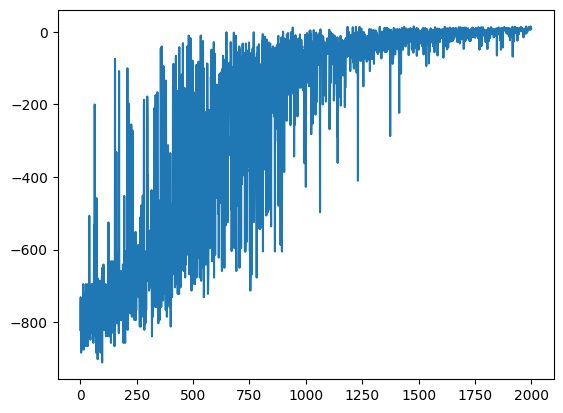

In [67]:
total_rewards = SARSA(env, episode_n=2000, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

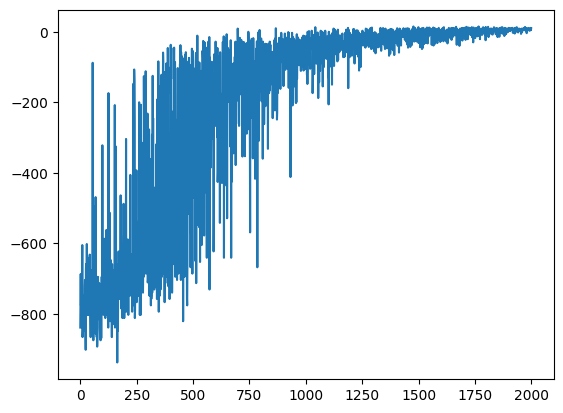

In [83]:
total_rewards = expected_SARSA(env, episode_n=2000, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

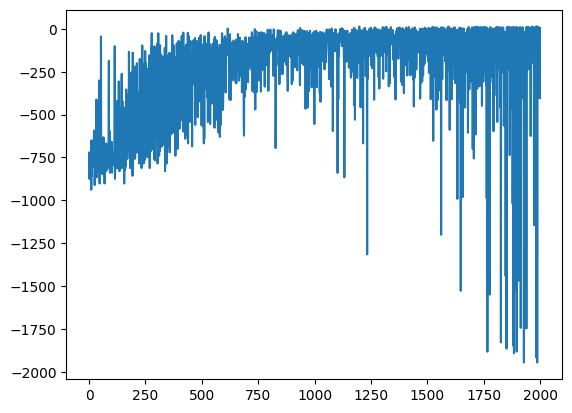

In [84]:
total_rewards = SARSA_with_replay_buffer(env, episode_n=2000, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

### Q-Learning Algorithm

Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [20]:
def QLearning(env, episode_n, trajectory_len=500, gamma=0.99, t_max=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)

        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][np.argmax(qfunction[next_state])] - qfunction[state][action])
            
            state = next_state
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            
            total_rewards[episode] += reward

            
            if done:
                break

    return total_rewards

In [75]:
def QLearning_with_replay_buffer(env, episode_n, trajectory_len=500, gamma=0.99, t_max=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)

        for _ in range(trajectory_len):
            global buffer
            state, action, reward, next_state,done = random.sample(buffer, 1)[0]
            qfunction[state][action] += (1 - done) * alpha * (reward + gamma * qfunction[next_state][np.argmax(qfunction[next_state])] - qfunction[state][action])
          
        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
        
            state = next_state
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            
            total_rewards[episode] += reward   

            if done:
                break
            


    return total_rewards

In [36]:
def QLearning_with_own_replay_buffer(env, episode_n, trajectory_len=500, gamma=0.99, t_max=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))

    buffer = []
    batch_size = 16
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)

        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            # этап сбора данных
            next_state, reward, done, _ = env.step(action)

            

            buffer.append([state, action, reward, next_state, done])
            
            # этап обновления q-функции
            # states, actions, rewards, next_states ,dones = list(zip(random.sample(buffer, batch_size)))
            if len(buffer) >= batch_size:
                batch = random.sample(buffer, batch_size)
                
                for _state, _action, _reward, _next_state, _done in batch:
                    qfunction[_state][_action] += (1 - _done) * alpha * (_reward + gamma * qfunction[_next_state][np.argmax(qfunction[_next_state])] - qfunction[_state][_action])
          
            
            # продолжение этапа сбора данных
            state = next_state
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            
            total_rewards[episode] += reward   

            if done:
                break
            


    return total_rewards

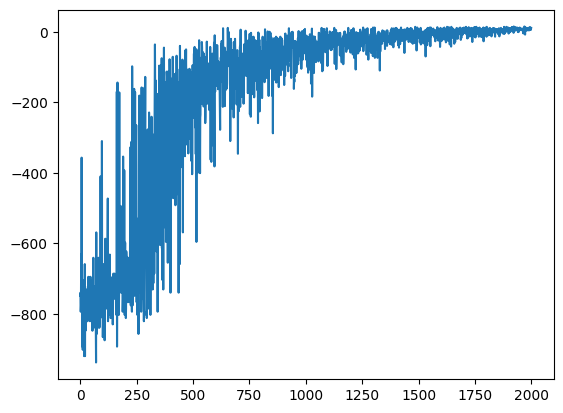

In [35]:
total_rewards = QLearning(env, episode_n=2000, trajectory_len=500, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

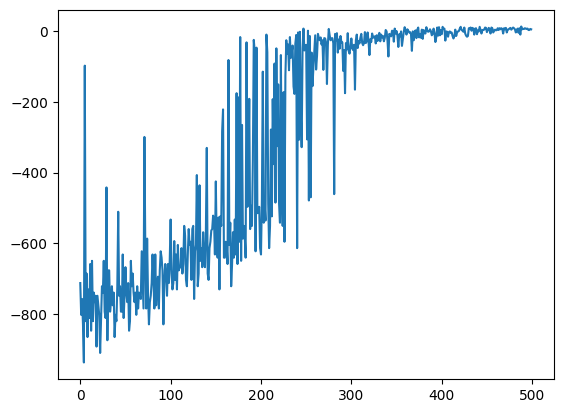

In [76]:
total_rewards = QLearning_with_replay_buffer(env, episode_n=500, trajectory_len=500, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

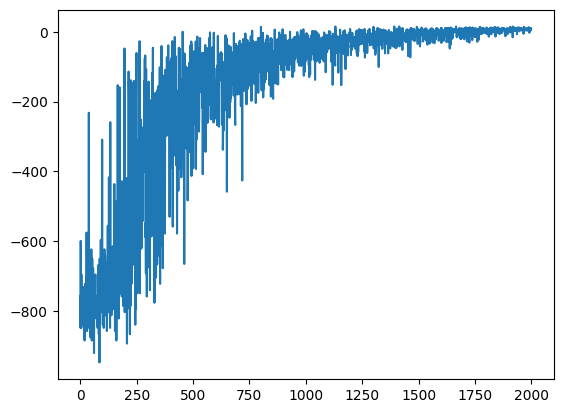

In [56]:
import gym
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3")

total_rewards = QLearning_with_own_replay_buffer(env, episode_n=2000, trajectory_len=500, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

In [64]:
from gym import ObservationWrapper

class MyObservationWrapper(ObservationWrapper):
    def __init__(self, env, dim_sizes):
        super().__init__(env)
        self.dim_sizes = np.array(dim_sizes)
        self.diff = np.array([high - low for high, low in zip(env.observation_space.low, env.observation_space.high)])
        self.multipliers = self.dim_sizes / self.diff
        self.additors = np.abs(env.observation_space.low)
        self.total_size = reduce(lambda a, b: a * b, self.dim_sizes)

    def observation(self, obs):
        # print(f'obs before: {obs}')
        new_obs = (np.array(obs) + self.additors) * self.multipliers
        new_obs = np.round(new_obs)
        # print(new_obs)
        rounded_obs = new_obs / self.multipliers - self.additors
        # print(f'obs after: {rounded_obs}')
        return hash(tuple(rounded_obs))

In [10]:
np.round(2.147, 1)

2.1

In [5]:
from functools import reduce 
a = [1, 2, 3, 4]
b = reduce(lambda x, y: x * y, a)
b

24

In [127]:
np.mean(a)

2.5

In [95]:
env = gym.make("LunarLander-v2")
env.observation_space.low
env.action_space.n

4

In [69]:
class QFunctionClass:
    def __init__(self):
        self.qdict = {}
        self.action_n = 4

    def __getitem__(self, k):
        k = str(k)
        if k in self.qdict:
            return self.qdict[k]
        else:
            self.qdict[k] = np.zeros(self.action_n)
            return self.qdict[k]

    def __setitem__(self, k, v):
        k = str(k)
        self.qdict[k] = v

In [8]:
def SARSA_modified(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)

    real_trajectory_lens = []

    action_n = env.action_space.n
    
    qfunction = QFunctionClass()
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / ( episode_n)
        
        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for i in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)
            
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])
            
            state = next_state
            action = next_action
            
            total_rewards[episode] += reward
            
            if done:
                real_trajectory_lens.append(i)     
                break

    return total_rewards, qfunction

In [87]:
def expected_SARSA_modified(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    action_n = env.action_space.n
    qfunction = QFunctionClass()
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)
        
        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)
            # global buffer
            # buffer.append([state, action, reward, next_state, next_action, done])
            qfunction[state][action] += alpha * (reward + gamma * get_math_expectation(qfunction[next_state], epsilon, action_n) - qfunction[state][action])
            
            state = next_state
            action = next_action
            
            total_rewards[episode] += reward
            
            if done:
                break
        print(f'{episode}: {total_rewards[episode]}')

    return total_rewards, qfunction

In [9]:
def QLearning_modified(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    action_n = env.action_space.n
    qfunction = QFunctionClass()
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)
        
        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][np.argmax(qfunction[next_state])] - qfunction[state][action])
            
            state = next_state
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            
            total_rewards[episode] += reward
            
            if done:
                break

    return total_rewards, qfunction

In [86]:
def QLearning_with_own_replay_buffer_modified(env, episode_n, trajectory_len=500, gamma=0.99, t_max=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    action_n = env.action_space.n
    qfunction = QFunctionClass()

    buffer = []
    batch_size = 16
    
    for episode in range(episode_n):
        epsilon = 1 -  episode / (episode_n)

        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            # этап сбора данных
            next_state, reward, done, _ = env.step(action)

            

            buffer.append([state, action, reward, next_state, done])
            
            # этап обновления q-функции
            # states, actions, rewards, next_states ,dones = list(zip(random.sample(buffer, batch_size)))
            if len(buffer) >= batch_size:
                batch = random.sample(buffer, batch_size)
                
                for _state, _action, _reward, _next_state, _done in batch:
                    qfunction[_state][_action] += (1 - _done) * alpha * (_reward + gamma * qfunction[_next_state][np.argmax(qfunction[_next_state])] - qfunction[_state][_action])
          
            
            # продолжение этапа сбора данных
            state = next_state
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            
            total_rewards[episode] += reward   

            if done:
                break
        print(f'{episode}: {total_rewards[episode]}')
            


    return total_rewards, qfunction

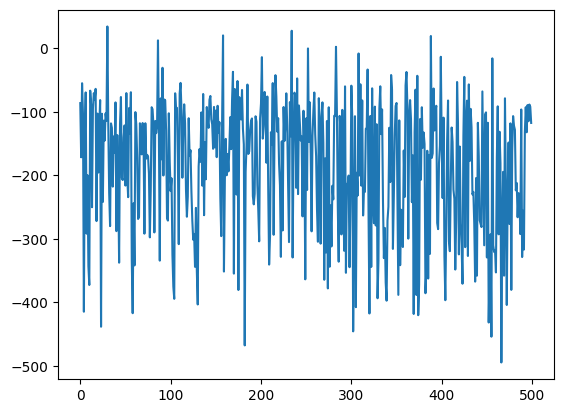

0


In [156]:
env = gym.make("LunarLander-v2")
dim_sizes = np.array([40, 40, 30, 30, 5, 10, 2, 2])
wrapped_env = MyObservationWrapper(env, dim_sizes)

total_rewards = QLearning_modified(wrapped_env, episode_n=500, gamma=0.99, trajectory_len=500, alpha=0.5)

plt.plot(total_rewards)
plt.show()
print(np.sum(np.array(real_lens) == 500))

In [78]:
def stats(qfunction):
    attended_states_count = len(qfunction.qdict.keys())
    print(f'number of attended states: {attended_states_count}')
    not_zero_count = sum([len(list(filter(lambda x: x != 0, values))) for values in qfunction.qdict.values()])
    print(f'number of non zero qvalues: {not_zero_count}')
    print(f'percent of non zero qvalues: {float(not_zero_count) / (4 * attended_states_count)}')

In [ ]:
env = gym.make("LunarLander-v2")
dim_sizes = np.array([40, 40, 30, 30, 5, 10, 2, 2])
wrapped_env = MyObservationWrapper(env, dim_sizes)

alphas = [0.8]
total_rewards_list = []
step = 1000
episode_n = 600000
for alpha in alphas:
    print(f'\n model expected SARSA with alpha={alpha}')
    start = time.time()
    total_rewards, qfunction = expected_SARSA_modified(wrapped_env, episode_n=episode_n, gamma=0.99, trajectory_len=500, alpha=alpha)
    total_rewards = total_rewards.tolist()
    with open(f'expected SARSA with alpha={alpha}, episode_n={episode_n} and cutted dim_sizes.json', 'w') as f:
        json.dump(total_rewards, f)
    learning_time = time.time() - start
    print(f'learning_time={np.round(learning_time, 1)}s')
    
    averaged_total_rewards = [np.mean(total_rewards[i:i+step]) for i in range(0, len(total_rewards), step)] 
    plt.plot(np.arange(len(averaged_total_rewards)) * step ,averaged_total_rewards, label=f'SARSA')
    plt.legend()
    stats(qfunction)
    plt.savefig(f'expected SARSA with alpha={alpha} episode_n={episode_n}.png')
    plt.clf()

alphas = [0.25]
step = 1000
episode_n = 600000
for alpha in alphas:
    print(f'\n model Q-Learning with alpha={alpha}')
    start = time.time()
    total_rewards, qfunction = QLearning_with_own_replay_buffer_modified(wrapped_env, episode_n=episode_n, gamma=0.99, trajectory_len=500, alpha=alpha)
    total_rewards = total_rewards.tolist()
    with open(f'Q-Learning with alpha={alpha}, episode_n={episode_n} and cutted dim_sizes.json', 'w') as f:
        json.dump(total_rewards, f)
    learning_time = time.time() - start
    print(f'learning_time={np.round(learning_time, 1)}s')

    averaged_total_rewards = [np.mean(total_rewards[i:i+step]) for i in range(0, len(total_rewards), step)] 
    plt.plot(np.arange(len(averaged_total_rewards)) * step ,averaged_total_rewards, label=f'Q-Learning')
    plt.legend()
    stats(qfunction)
    plt.savefig(f'Q-Learning with replay buffer with alpha={alpha} episode_n={episode_n}.png')
    plt.clf()
    
    

#### способы улучшения и гипотезы
- создать среду с другой сеткой
- применить приоретизированный буфер

ModuleNotFoundError: No module named 'torchrl'

### Делаем ДЗ

In [9]:
class CrossEntropyAgent:
		def __init__(self, state_n=25, action_n=4, smoothing=None, alpha=None):
			self.state_n = state_n
			self.action_n = action_n
			self.model = np.ones((self.state_n, self.action_n), dtype=float) / self.action_n

			self.smoothing_types = ['laplace', 'policy']
			if smoothing is None:
				return
			elif smoothing in self.smoothing_types:
				self.smoothing = smoothing
			else:
				raise NotImplementedError()

			self.init_alpha = alpha
			self.alpha = alpha
			self.with_alpha_decay = False
			self.counter = 1


		def get_action(self, state):
			action = np.random.choice(self.action_n, p=self.model[state])
			return action

		def fit(self, elite_trajectories):
			new_model = np.zeros((self.state_n, self.action_n), dtype=float)

			for trajectory in elite_trajectories:
				for state, action in zip(trajectory['states'], trajectory['actions']):
					new_model[state][action] += 1

			if self.smoothing is None:
				for state in range(self.state_n):
					if np.sum(new_model[state]) > 0:
						new_model[state] /= np.sum(new_model[state])
					else:
						new_model[state] = self.model[state].copy()
				self.model = new_model
				
			elif self.smoothing == 'laplace':
				for state in range(self.state_n):
					new_model[state] = (new_model[state] + self.alpha) / (np.sum(new_model[state]) + self.alpha * self.action_n)
				self.model = new_model

			elif self.smoothing == 'policy':
				for state in range(self.state_n):
					if np.sum(new_model[state]) > 0:
						new_model[state] /= np.sum(new_model[state])
					else:
						new_model[state] = self.model[state].copy()
				self.model = self.alpha * new_model + (1 - self.alpha) * self.model

			if self.with_alpha_decay:
				self.alpha = self.init_alpha * np.exp(-0.01*self.counter)
				self.counter += 1

			return None


def get_trajectory(agent, env, max_len=1000, visualize=False):
	trajectory = {'states': [], 'actions': [], 'rewards': []}

	state = env.reset()


	for i in range(max_len):
		trajectory['states'].append(state)

		action = agent.get_action(state)
		trajectory['actions'].append(action)

		next_state, reward, done, _ = env.step(action)
		trajectory['rewards'].append(reward)


		if visualize:
			print(f'iteration: {i}, state: {state}, action: {action}, reward: {reward}')
			env.render()
			time.sleep(0.02)

		if done:
			return trajectory

		state = next_state

	return trajectory


def CEM(agent, env, n_iterations, k_samples, q):
	average_rewards = []
	#обучение
	for i in range(n_iterations):
		trajectories = [get_trajectory(agent, env) for _ in range(k_samples)]

		#оценка модели
		total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
		average_rewards.append(np.mean(total_rewards))
		print(f'mean reward on {i} iteration: {np.mean(total_rewards)}', end='\r')

		elite_trajectories = []
		quantile = np.quantile(total_rewards, q)
		for trajectory in trajectories:
			if np.sum(trajectory['rewards']) > quantile:
				elite_trajectories.append(trajectory)

		#улучшение модели
		agent.fit(elite_trajectories)

	return agent, average_rewards

In [12]:
env = gym.make("Taxi-v3")

agent = CrossEntropyAgent(state_n=500 , action_n=env.action_space.n, smoothing='policy', alpha=0.1)
_, cem_rewards = CEM(agent, env, 250, 40, 0.5)

In [18]:
mc_rewards = MonteCarlo(env, episode_n=10000, trajectory_len=1000, gamma=0.99)

In [39]:
sar_rewards = SARSA(env, episode_n=10000, trajectory_len=10000, gamma=0.999, alpha=0.5)

In [40]:
ql_rewards = QLearning(env, episode_n=10000, trajectory_len=500, t_max=1000, gamma=0.999, alpha=0.5)

In [31]:
mc_rewards = [np.mean(mc_rewards[i:i+step]) for i in range(len(mc_rewards))]

In [41]:
sar_rewards = [np.mean(sar_rewards[i:i+step]) for i in range(len(sar_rewards))]

In [42]:
ql_rewards = [np.mean(ql_rewards[i:i+step]) for i in range(len(ql_rewards))]

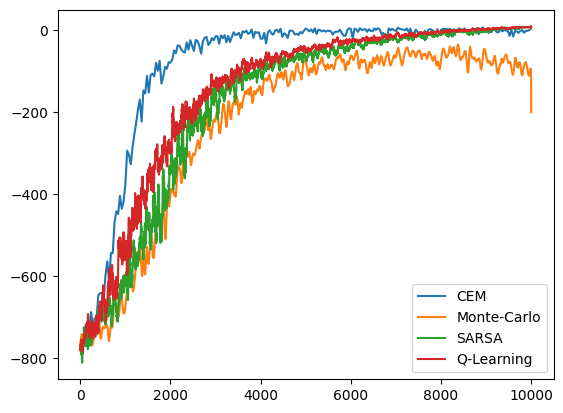

In [43]:
step = 40
plt.plot(np.arange(0, 10000, step) ,cem_rewards, label='CEM')
plt.plot(mc_rewards, label='Monte-Carlo')
plt.plot(sar_rewards, label='SARSA')
plt.plot(ql_rewards, label='Q-Learning')
plt.legend()
plt.show()

In [62]:

import torch
from torch import nn 
from torch.utils.data import DataLoader, Dataset

import numpy as np
import gym
import matplotlib.pyplot as plt

import time


class CEM(nn.Module):
    def __init__(self, state_dim, action_n, batch_size=128):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.fc1 = nn.Linear(state_dim, 64)
        torch.nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(64, action_n)
        torch.nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.rl1 = nn.ReLU()
        
        self.network = nn.Sequential(
            self.fc1, 
            self.rl1, 
            self.fc2
        )

        self.layers_list = [self.network[0], self.network[2]]
        
        self.softmax = nn.Softmax(dim=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[150, 225], gamma=0.5)
        self.loss = nn.CrossEntropyLoss()

        self.gradient_norms = []
        self.losses = []

        self.batch_size = batch_size
        
    def forward(self, _input):
        return self.network(_input) 
    
    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        #print(elite_states)
        #print(elite_actions)
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)

        train_dataset = list(zip(elite_states, elite_actions))
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        grad_norm = []
        iter_loss = []
        for x_batch, y_batch in train_loader:
            y_batch_pred = self.forward(x_batch)

            loss = self.loss(y_batch_pred, y_batch)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

        self.scheduler.step()
        
        
def get_trajectory(env, agent, trajectory_len = 1000, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)
    
    for _ in range(trajectory_len):
        
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        if visualize:
            env.render()
            
        trajectory['states'].append(state)
            
    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]


def teach_model(env, agent, episode_n, trajectory_n, q_param):  
    average_rewards = []
    training_time_start = time.time()
    for episode in range(episode_n):
        start = time.time()
        trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
        
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
        average_rewards.append(mean_total_reward)
        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        
        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)
        print(f'episode: {episode}, mean_total_reward = {mean_total_reward}  ### time: {time.time() - start}')
    print(f'##### total training time: {time.time() - training_time_start}')

    return agent, average_rewards  

  


def grid_search_k_v(env, episode_n, k_list, q_list, batch_sizes):
    plt.figure(figsize=(45, 15))
    for k in k_list:
        for q in q_list:
            for batch_size in batch_sizes:
                print(f'learn simple model with parameters: k={k}, q={q}, batch_size={batch_size}')
                agent = CEM(8, 4, batch_size)
                agent, rewards =teach_model(env, agent, episode_n, k, q)
                with open(f'simple DCEM batch_size={batch_size}.txt', 'w') as f:
                        json.dump(rewards,f)
                plt.plot(rewards, label=f'q={q}, max={np.max(rewards)}')
                plt.legend()
        plt.savefig(f'simple LunarLander with mini-batches k={k}.png')
        plt.clf()


env = gym.make('LunarLander-v2')
state_dim = 8
action_n = 4

external_buffer = []

episode_n = 250

k_list = [60]
q_list = [0.7]
batch_sizes = [128]

grid_search_k_v(env, episode_n, k_list, q_list, batch_sizes)

learn simple model with parameters: k=60, q=0.7, batch_size=128
episode: 0, mean_total_reward = -197.5598406918011  ### time: 0.6989777088165283
episode: 1, mean_total_reward = -161.5511347754026  ### time: 0.7401633262634277
episode: 2, mean_total_reward = -145.20865182312284  ### time: 0.7229979038238525
episode: 3, mean_total_reward = -147.35859285853877  ### time: 0.7949328422546387
episode: 4, mean_total_reward = -117.23856279822402  ### time: 0.8016541004180908
episode: 5, mean_total_reward = -137.25875362337237  ### time: 0.8354816436767578
episode: 6, mean_total_reward = -120.06383614759712  ### time: 0.825596809387207
episode: 7, mean_total_reward = -92.9620106243855  ### time: 0.7928125858306885
episode: 8, mean_total_reward = -123.6391774629742  ### time: 0.8092305660247803
episode: 9, mean_total_reward = -122.88084970036157  ### time: 0.7794589996337891
episode: 10, mean_total_reward = -113.39487631566544  ### time: 0.7955474853515625
episode: 11, mean_total_reward = -84.78

KeyboardInterrupt: 

<Figure size 4500x1500 with 0 Axes>

In [53]:
with open('simple DCEM.txt', 'w') as f:
    for line in external_buffer:
        f.write(str(line))